# In this notebook
I look at the relationship between the station intensity and income.

I also find that we can totally use the neighboring census tracts to get a reasonable income level to use for analysis.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt

import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_12232/2087585347.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# This code loads the census tract shapefile for Durham County
block_groups = gpd.read_file('../data/preprocessed/census_blocks/durham_block_group.shp')

In [4]:
print(len(block_groups))

238


In [6]:
block_groups['income'].values

array([ 78324.,  75729.,     nan,  78250., 120875.,  48036.,  44250.,
        81545.,  67000.,  74895.,     nan,  81590., 128167.,  84625.,
        28854., 113333., 110324.,  70840.,  27021., 163420.,  50560.,
        57886.,  65948.,  76771.,  35327.,  49601.,  82228.,  84073.,
        25457.,  28311., 183317., 107693., 121075.,  49297.,  74549.,
        58703.,  69444.,  45441., 122273.,  92454.,  43780.,  84323.,
        43781., 111538.,  25058.,     nan, 100057.,  70313.,  86029.,
        74333.,  74271.,     nan, 103101.,  31621., 164688.,  76174.,
        70536.,  69011., 174432.,  45000.,  84261.,  60507.,  47803.,
           nan, 124000., 100341.,  68077.,  63750., 109531.,  65230.,
       163707.,  74559.,     nan,  44960.,  34245.,     nan,  91146.,
        44844.,     nan,  73269.,  70833., 115625.,  93681.,  70795.,
        29795., 111250., 102232.,  72891.,  34189., 110682., 114891.,
        95035.,  54515.,  94549.,  95833.,  35313., 121953.,     nan,
        62554., 1157

Text(0.5, 1.0, 'Median Household Income in Durham County, 2020, by Census Tract')

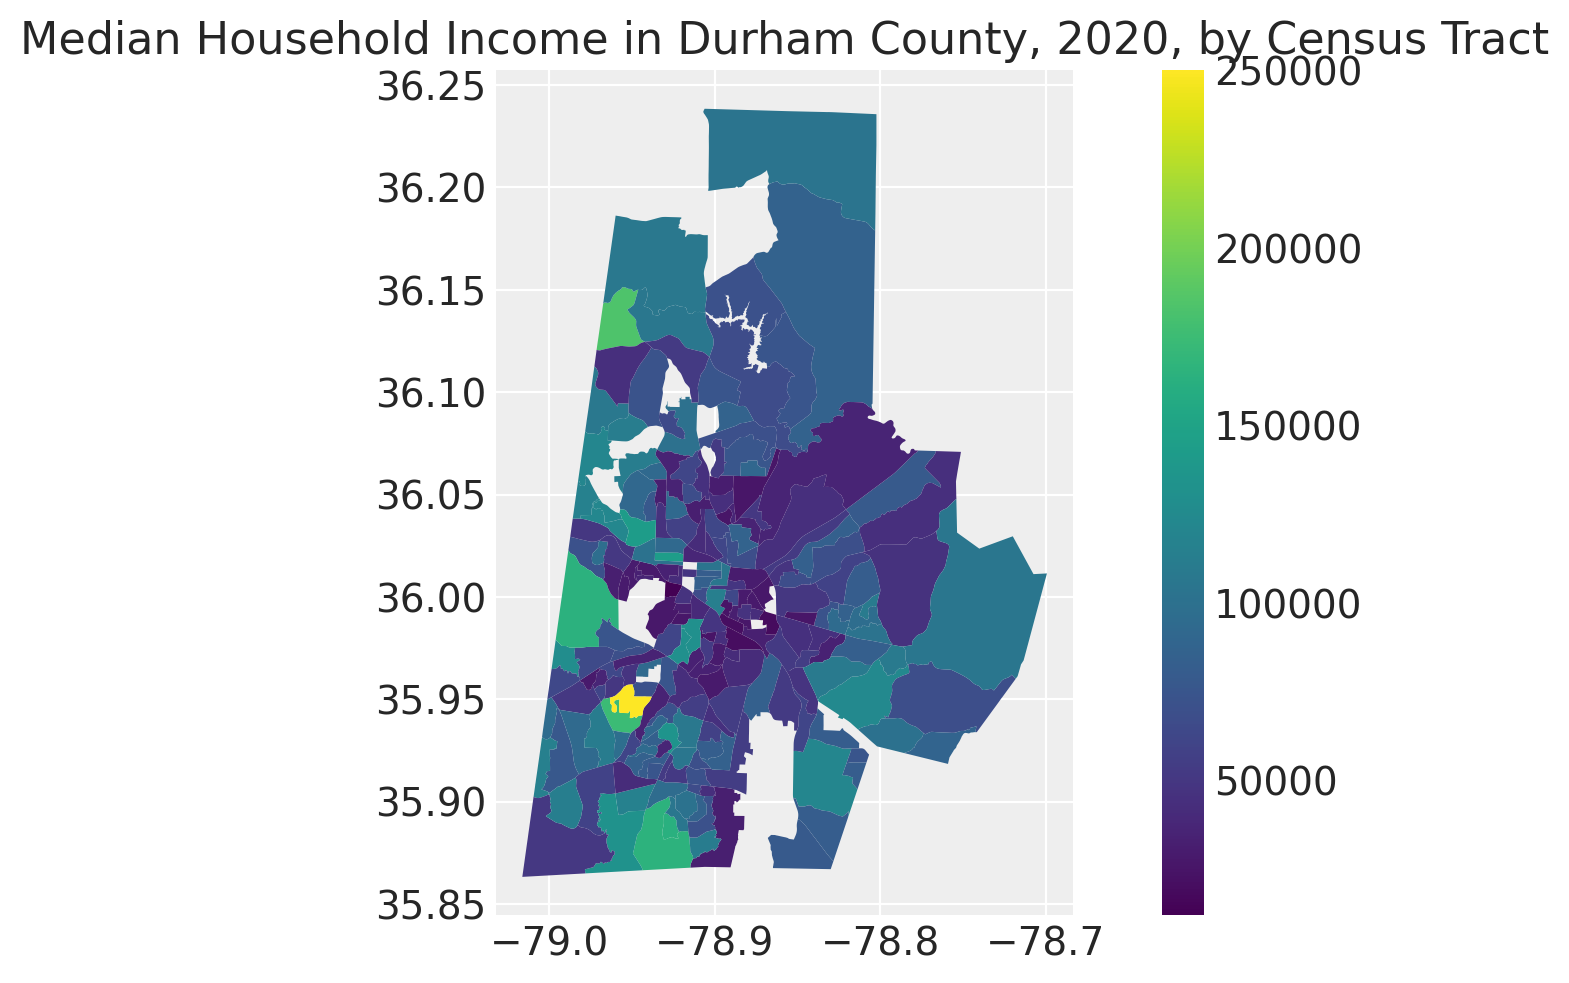

In [7]:
block_groups.plot(column='income', legend=True)
plt.title("Median Household Income in Durham County, 2020, by Census Tract")

# Now, let's merge the station data with this data

In [8]:
# Read in the station data
stations = pd.read_csv('../data/raw/temperature/weather_underground/durham_stations.csv')
stations = stations[stations['qcStatus'] == 1]

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_12232/2455566404.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(stations['longitude'], stations['latitude'], 'k.', color='black', label='Station')


<Figure size 1000x1000 with 0 Axes>

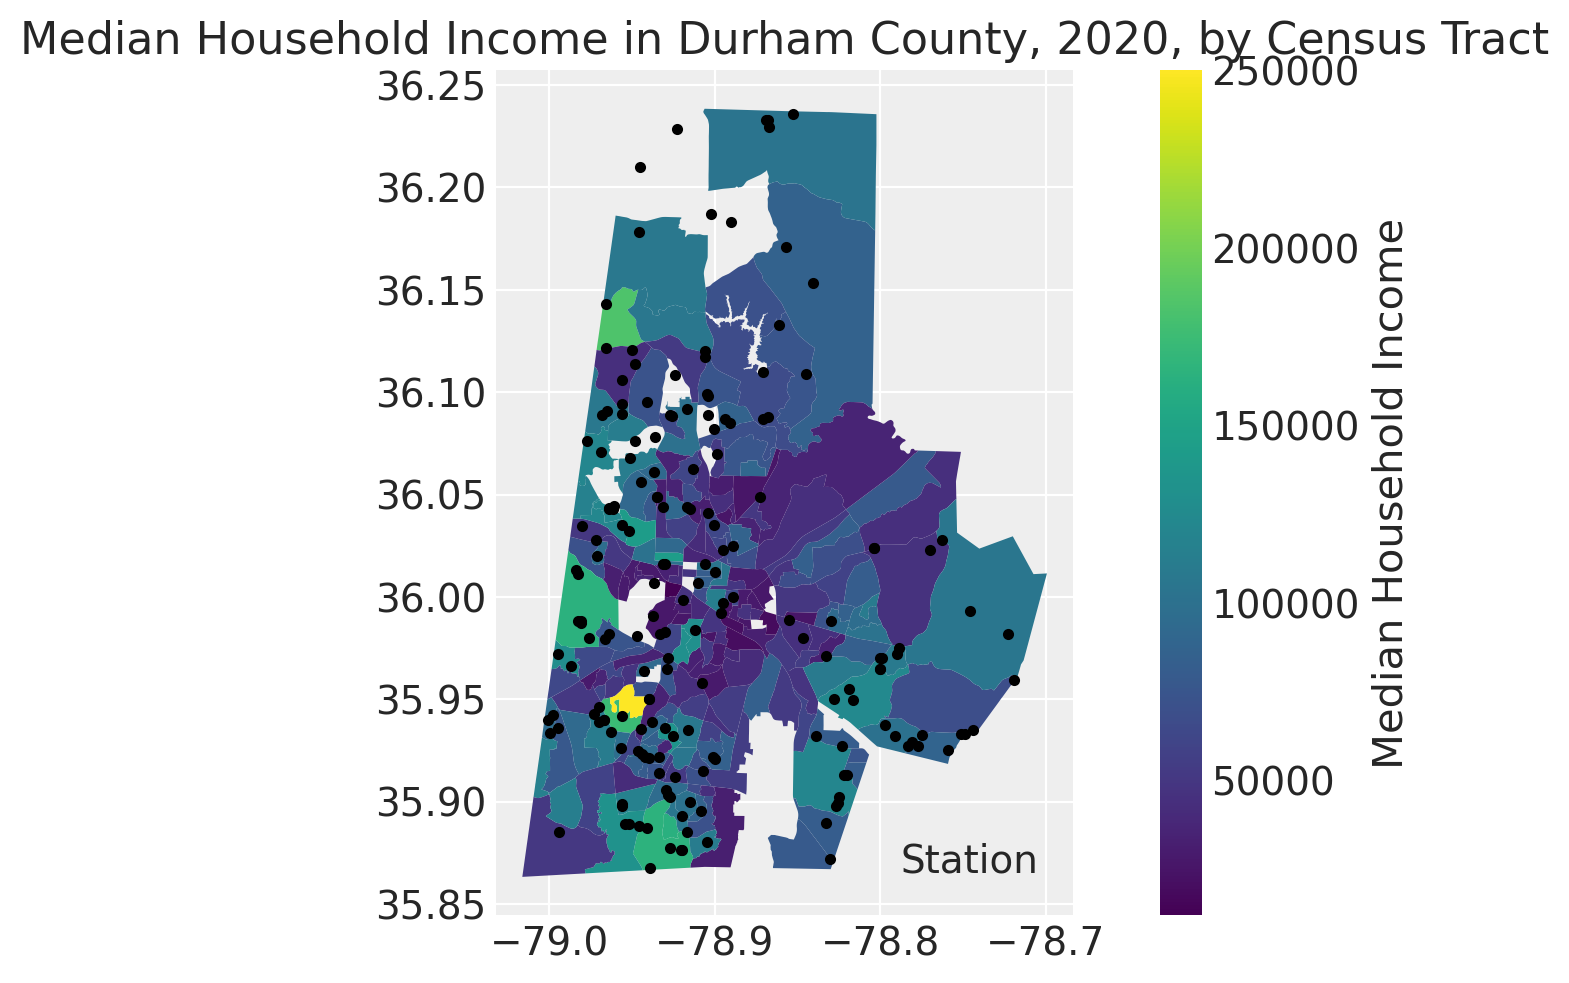

In [9]:
plt.figure(figsize=(10,10))
block_groups.plot(column='income', legend=True, cmap='viridis', legend_kwds={
    "label": "Median Household Income"
})
plt.title("Median Household Income in Durham County, 2020, by Census Tract")
plt.plot(stations['longitude'], stations['latitude'], 'k.', color='black', label='Station')
plt.legend()
plt.show()

In [11]:
block_groups.columns

Index(['geoid', 'landarea', 'waterarea', 'pop', 'pop_error', 'income',
       'income_err', 'geometry'],
      dtype='object')

In [12]:


num_stations = []
income = []
aland = []
population = []
geometry = []
for i, row in block_groups.iterrows():
    count = 0
    for j, s in stations.iterrows():
        # Check if station is in polygon
        p = Point(s['longitude'], s['latitude'])
        if row.geometry.contains(p):
            count += 1
    num_stations.append(count)

    income.append(row['income'])
    aland.append(row['landarea'])
    population.append(row['pop'])
    geometry.append(row['geometry'])

In [13]:
assert len(income) == len(aland) == len(num_stations) == len(population)

In [14]:
count_data = pd.DataFrame({
    "num_stations": num_stations,
    "income": income,
    "area": aland,
    "population": population,
    "geometry": geometry
})

In [15]:
count_data.head()

,num_stations,income,area,population,geometry
0,0,78324.0,6464902.0,900.0,POLYGON ((-78.82078599967411 36.04266099970545...
1,0,75729.0,3576476.0,1175.0,POLYGON ((-78.89638200002923 36.05947099968694...
2,0,NaN,853369.0,0.0,POLYGON ((-78.90575000036216 36.13901100025748...
3,0,78250.0,5587220.0,2168.0,"POLYGON ((-78.86797500034595 35.8822409997224,..."
4,3,120875.0,10845441.0,1911.0,POLYGON ((-78.85279399994312 35.90356199998638...


In [16]:
count_data['num_stations'].values

array([0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 4, 2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 2, 1,
       0, 0, 1, 0, 2, 2, 2, 2, 4, 0, 6, 1, 1, 0, 1, 0, 0, 0, 0, 0, 5, 5,
       1, 0, 4, 0, 6, 2, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 6, 0, 0,
       1, 1, 0, 3, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1,
       2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 3, 0, 1, 1, 1, 0, 0, 2, 0, 0, 4,
       3, 0, 2, 3, 1, 3, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0])

In [17]:
len(count_data)

238

# Finally, the data is here
This data set has four columns: num_stations, income, area, and population. Together, we can create a model to look at the effect of income on the intensity.

But first, we should verify to what extent normalization is required.

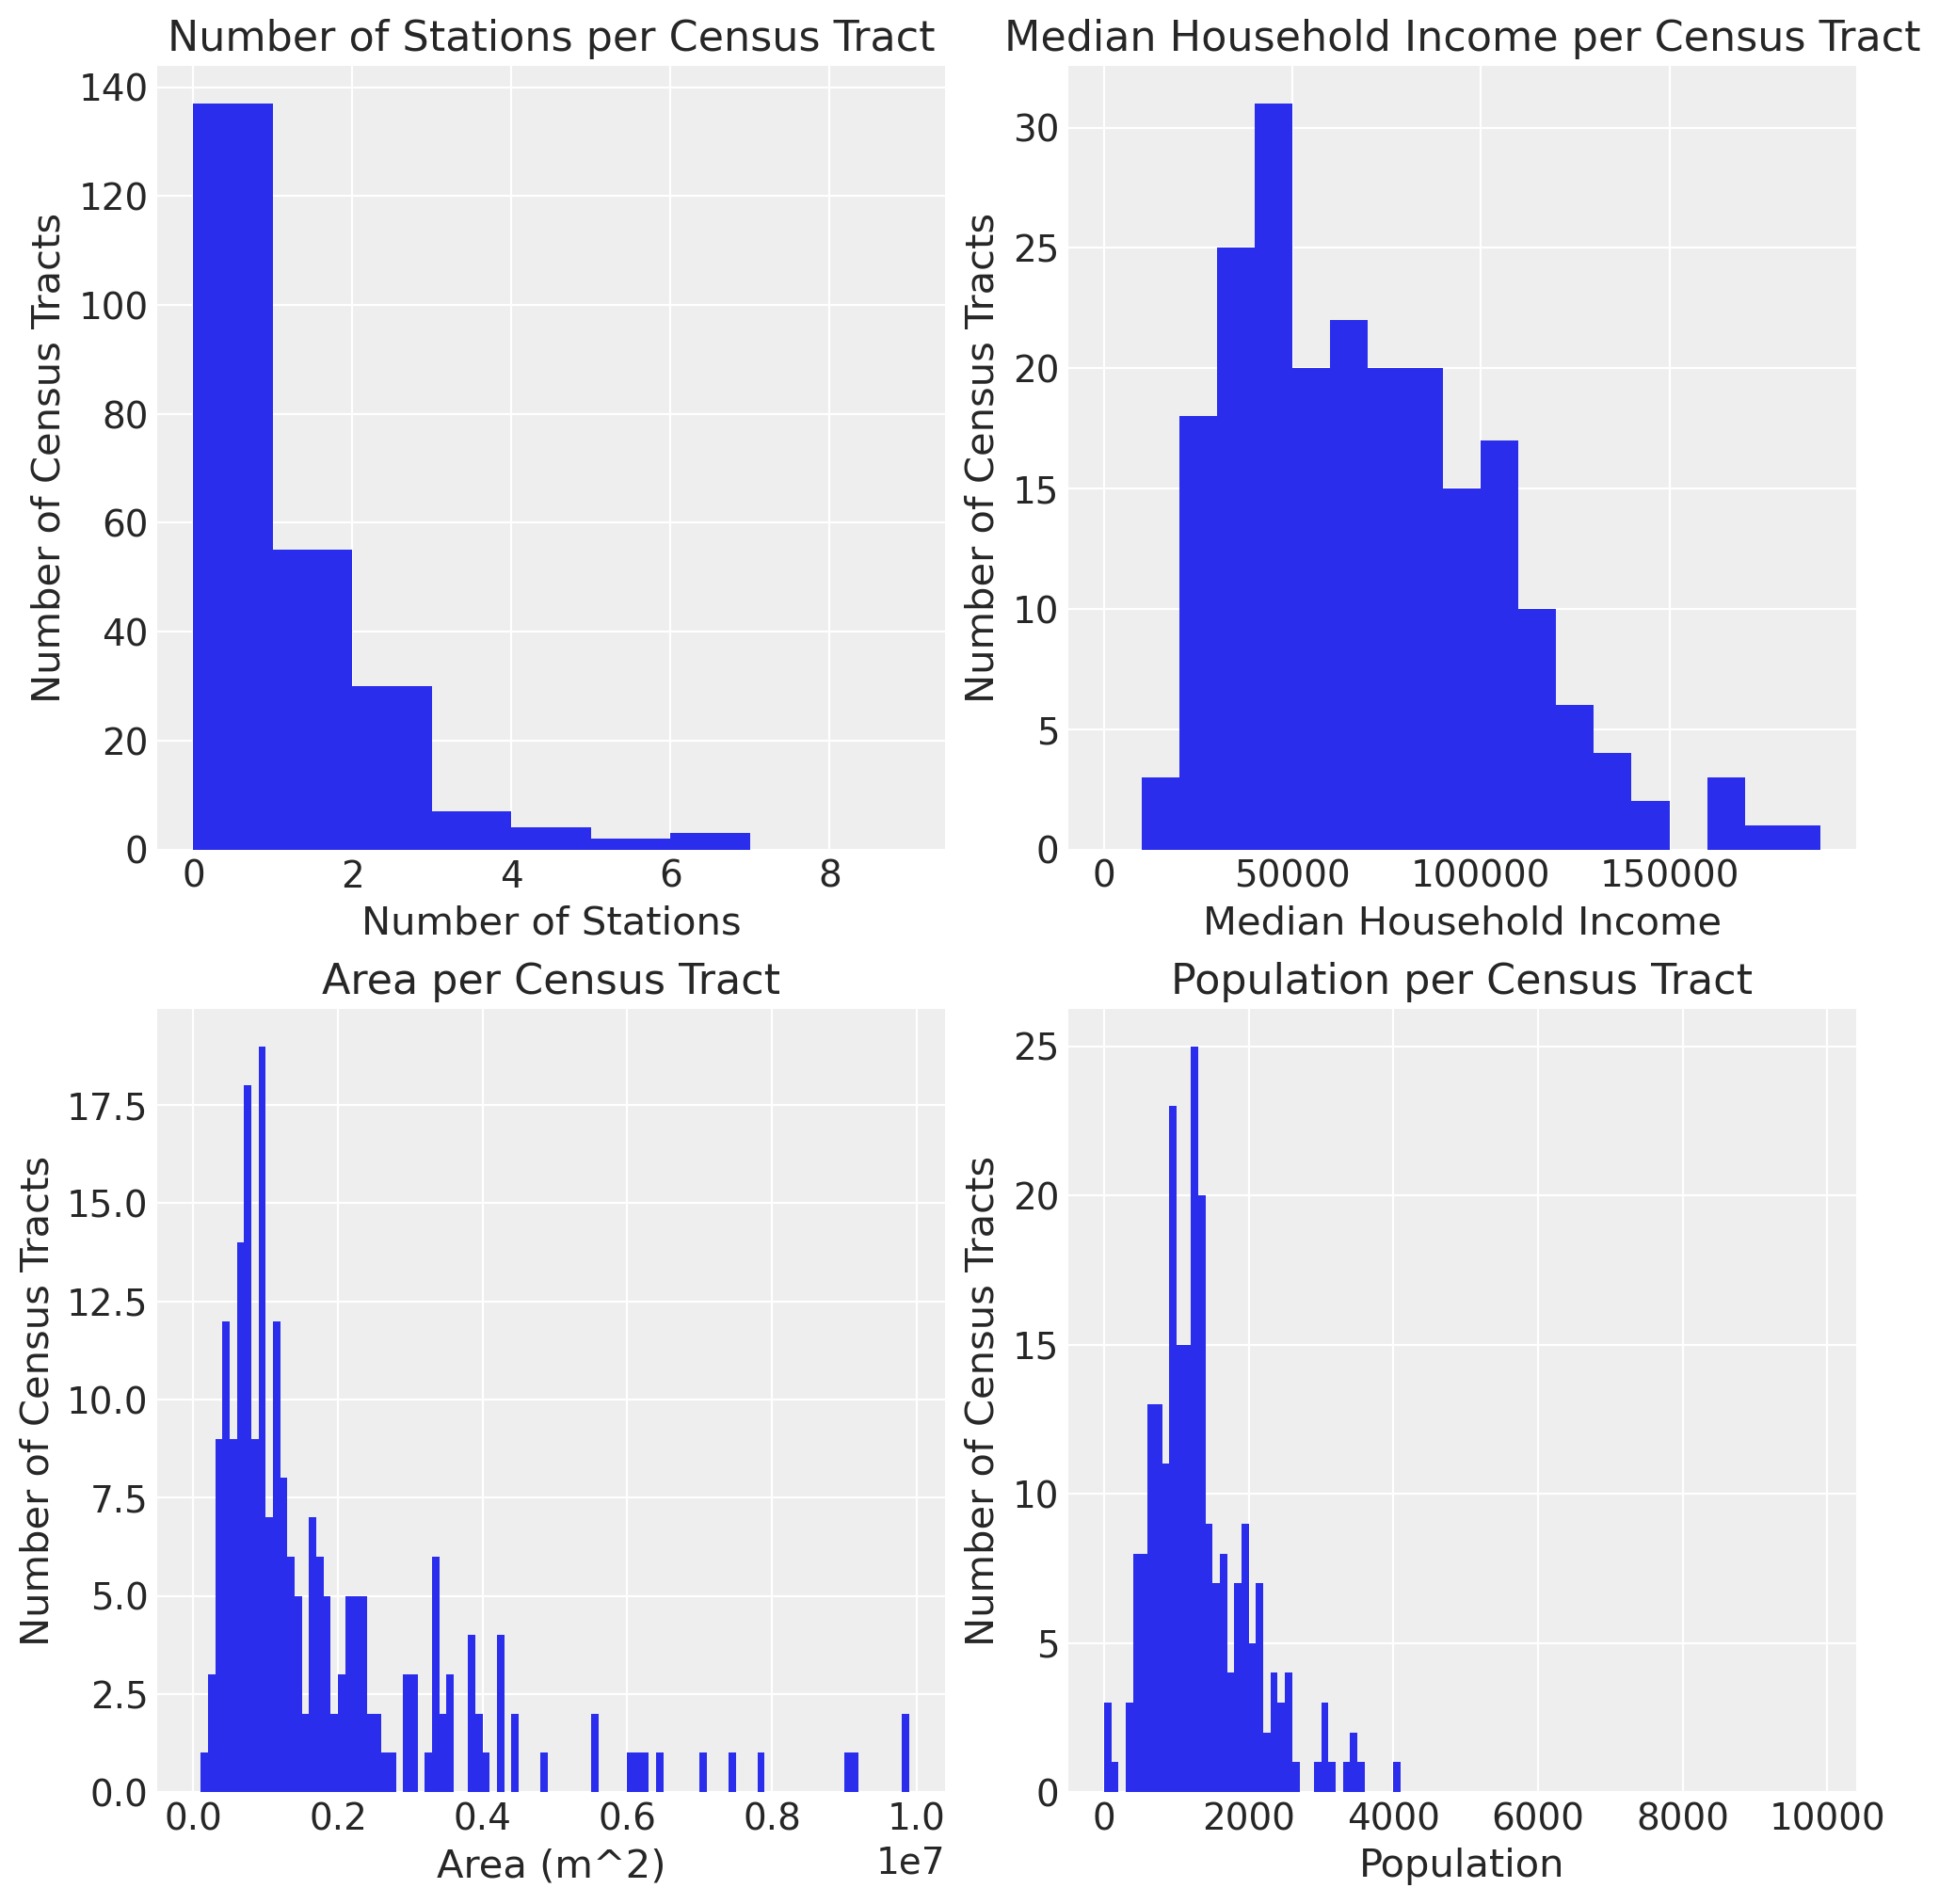

In [18]:
plt.subplots(2,2, figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(count_data['num_stations'], bins=range(0,10))
plt.xlabel("Number of Stations")
plt.ylabel("Number of Census Tracts")
plt.title("Number of Stations per Census Tract")

plt.subplot(2,2,2)
plt.hist(count_data['income'], bins=range(0,200000,10000))
plt.xlabel("Median Household Income")
plt.ylabel("Number of Census Tracts")
plt.title("Median Household Income per Census Tract")

plt.subplot(2,2,3)
plt.hist(count_data['area'], bins=range(0,10000000,100000))
plt.xlabel("Area (m^2)")
plt.ylabel("Number of Census Tracts")
plt.title("Area per Census Tract")

plt.subplot(2,2,4)
plt.hist(count_data['population'], bins=range(0,10000,100))
plt.xlabel("Population")
plt.ylabel("Number of Census Tracts")
plt.title("Population per Census Tract")

plt.show()


Are there any weird values?

In [19]:
# Are there missing values?
print(sum(count_data['income'].isna()))

# Is there a place with no population?
print(sum(count_data['population'] == 0))

19
3


In [20]:
count_data['num_stations'][count_data['income'].isna()]

2      0
10     0
45     0
51     2
63     0
72     1
75     2
78     1
97     1
106    0
112    1
138    0
144    0
149    1
151    0
152    2
194    2
195    0
229    0
Name: num_stations, dtype: int64

Ok, so there is one census tract with zero people, and three with no income data...these are all affiliated with Duke University or research triangle park. 

My thinking is that we remove the census tract with zero population, and then we get the spatial mean temperature for the remaining census tracts (just get the average of all of the incomes surrounding that location).

Alternatively, we could completely remove these communities from the map, but I think that is in poor form for this kind of analysis.

In [21]:
# Remove the row with no population
count_data = count_data[count_data['population'] != 0]
print(len(count_data))

235


In [22]:
no_income_mask = count_data[count_data['income'].isna()]

In [23]:
count_data.head()

,num_stations,income,area,population,geometry
0,0,78324.0,6464902.0,900.0,POLYGON ((-78.82078599967411 36.04266099970545...
1,0,75729.0,3576476.0,1175.0,POLYGON ((-78.89638200002923 36.05947099968694...
3,0,78250.0,5587220.0,2168.0,"POLYGON ((-78.86797500034595 35.8822409997224,..."
4,3,120875.0,10845441.0,1911.0,POLYGON ((-78.85279399994312 35.90356199998638...
5,0,48036.0,963243.0,1383.0,POLYGON ((-78.86737299956422 36.01021299983012...


In [24]:

no_income_mask

,num_stations,income,area,population,geometry
45,0,NaN,708095.0,898.0,POLYGON ((-78.9086140002359 36.072032999823136...
51,2,NaN,28719939.0,936.0,POLYGON ((-78.95991299978505 36.18626400028341...
63,0,NaN,2347812.0,799.0,POLYGON ((-78.83771000041617 35.94727200030263...
72,1,NaN,2999023.0,661.0,POLYGON ((-78.95831399979124 35.99871100001269...
75,2,NaN,2976881.0,1373.0,"POLYGON ((-78.97803600006131 36.0593260001948,..."
78,1,NaN,1207791.0,543.0,POLYGON ((-78.94398500000773 36.08075700013552...
97,1,NaN,1703637.0,637.0,"POLYGON ((-78.964226999976 36.07454499965206, ..."
106,0,NaN,346929.0,772.0,POLYGON ((-78.87834800025996 35.98886700021194...
112,1,NaN,2613156.0,1633.0,POLYGON ((-78.93333900009475 36.09025099998371...
144,0,NaN,604931.0,1393.0,POLYGON ((-78.87021500022206 35.99391600012336...


In [25]:
import libpysal
from libpysal.weights import Rook

w = Rook.from_dataframe(count_data)

for no_income in no_income_mask.index:
    neighbors = w.neighbors[no_income]
    print(neighbors)
    print(count_data['income'][neighbors])
    no_income_neighbors = count_data['income'].values[neighbors].mean()

    count_data.loc[no_income, 'income'] = no_income_neighbors

[1, 195, 149, 166, 43, 44, 203]
1       75729.0
195         NaN
149         NaN
166    106750.0
43     111538.0
44      25058.0
203    105703.0
Name: income, dtype: float64
[160, 116, 52, 100, 87]
160     61750.0
116     92500.0
52     103101.0
100     44130.0
87      72891.0
Name: income, dtype: float64
[64, 194, 61, 62]
64     124000.0
194         NaN
61      60507.0
62      47803.0
Name: income, dtype: float64
[105, 82, 22]
105    24707.0
82     93681.0
22     65948.0
Name: income, dtype: float64
[156, 38, 168, 153, 43, 44, 157]
156     32069.0
38     122273.0
168    142994.0
153     46786.0
43     111538.0
44      25058.0
157     50444.0
Name: income, dtype: float64
[48, 212, 46, 191]
48      86029.0
212    101994.0
46     100057.0
191     84871.0
Name: income, dtype: float64
[131, 180, 181, 52]
131     44438.0
180     81250.0
181     47526.0
52     103101.0
Name: income, dtype: float64
[150, 103, 230, 199, 204, 142]
150     28897.0
103    111574.0
230     41500.0
199     70833.0
2

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_12232/3940928076.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Rook.from_dataframe(count_data)


In [26]:
count_data.head()

,num_stations,income,area,population,geometry
0,0,78324.0,6464902.0,900.0,POLYGON ((-78.82078599967411 36.04266099970545...
1,0,75729.0,3576476.0,1175.0,POLYGON ((-78.89638200002923 36.05947099968694...
3,0,78250.0,5587220.0,2168.0,"POLYGON ((-78.86797500034595 35.8822409997224,..."
4,3,120875.0,10845441.0,1911.0,POLYGON ((-78.85279399994312 35.90356199998638...
5,0,48036.0,963243.0,1383.0,POLYGON ((-78.86737299956422 36.01021299983012...


In [27]:
# Remove the row with no population
count_data = count_data[count_data['population'] != 0]

# When income is missing, set it to the mean
count_data['income'] = count_data['income'].fillna(count_data['income'].mean())

In [28]:
count_data.iloc[19]

num_stations                                                    0
income                                                    57886.0
area                                                    1058327.0
population                                                 1242.0
geometry        POLYGON ((-78.91029300032164 35.92987200009276...
Name: 21, dtype: object

In [29]:
print(len(count_data))

235


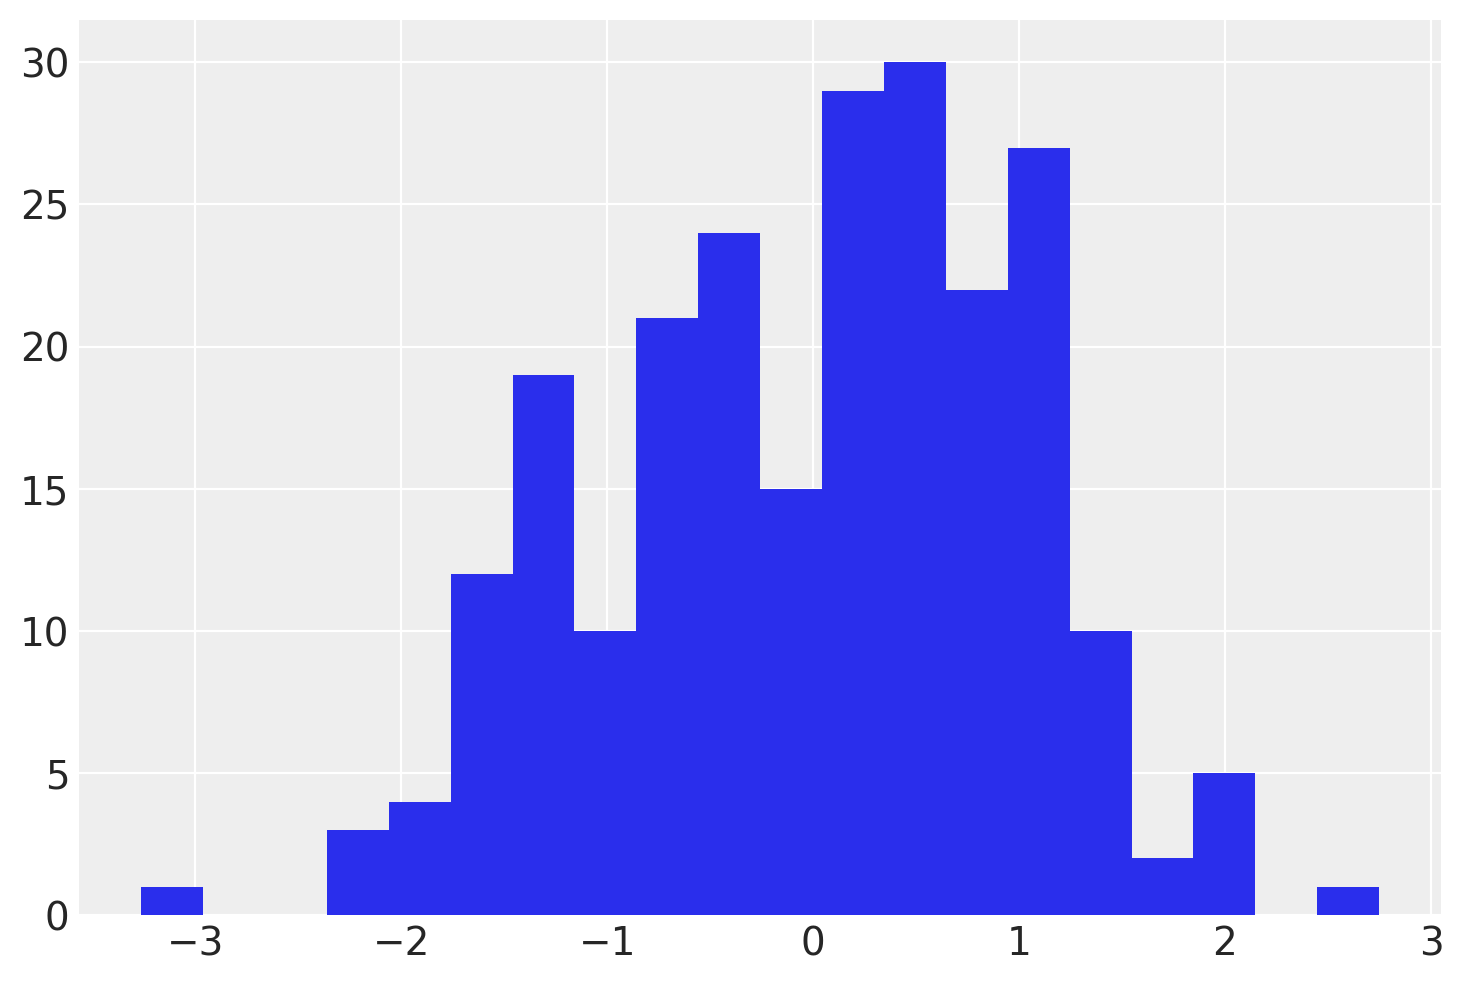

In [30]:
# Let's just normalize income
# mask = count_data['income'].isna()
log_income = np.log(count_data['income'].values)
# Turn this into a masked array with nan values turned to masks
# log_income = np.ma.masked_invalid(log_income)
# log_income = np.log(count_data['income'].values)
log_income_std = (log_income - np.mean(log_income)) / np.std(log_income)
plt.hist(log_income_std, bins=20)
plt.show()

This looks like a reasonable normalization for income -- although I don't think this is going to matter too much. The important thing is that the data is standardized around the mean.

To make our data in reasonable units, let's convert area to be in square KM and population in 1000 people.

In [32]:
area = count_data['area'].values / 1e6
population = count_data['population'].values / 1e3
num_stations = count_data['num_stations'].values

# Looking at intensity, normalized by area

In [33]:

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    log_intensity = alpha + beta * log_income_std
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area

    counts = pm.Poisson('counts', mu=rates, observed=num_stations)

In [34]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

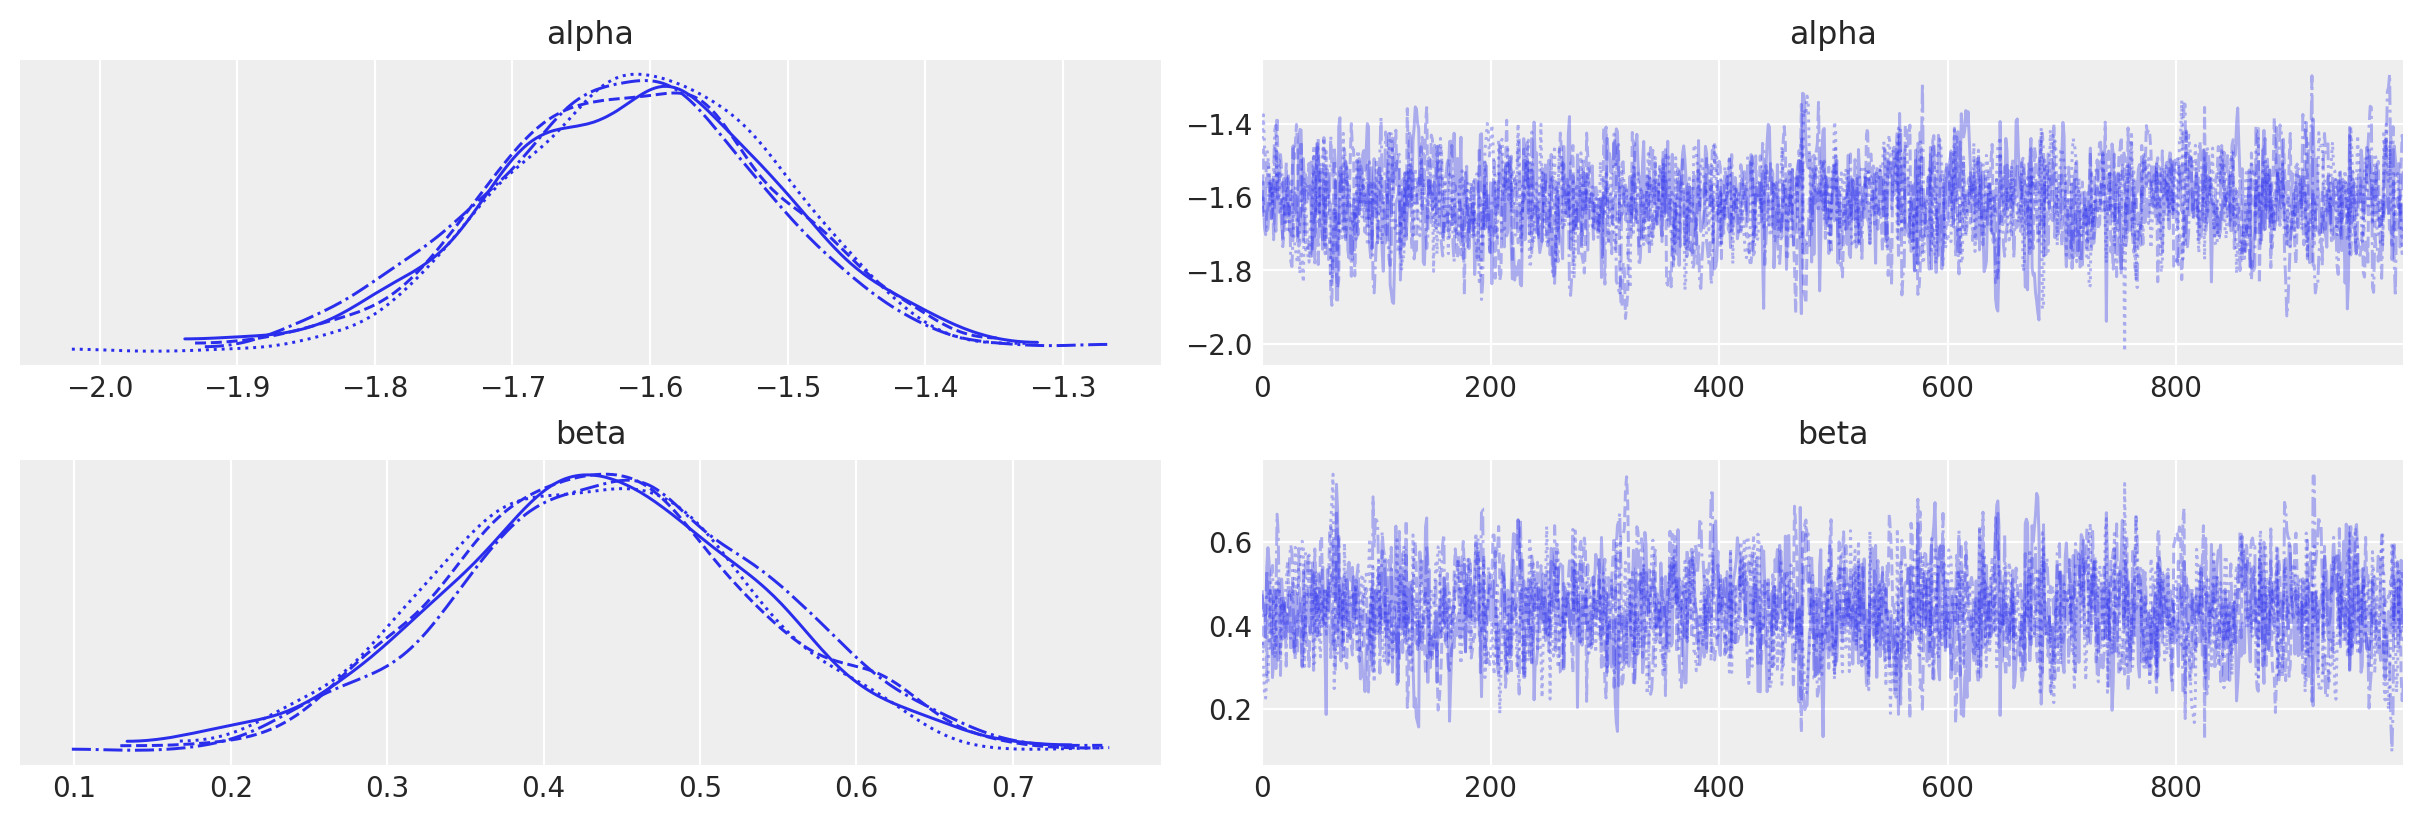

In [35]:
import arviz as az

az.plot_trace(trace)

In [36]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.612,0.102,-1.797,-1.415,0.003,0.002,1480.0,1631.0,1.0
beta,0.437,0.098,0.258,0.625,0.003,0.002,1423.0,1550.0,1.0


Text(0, 0.5, 'Intensity (stations / km^2)')

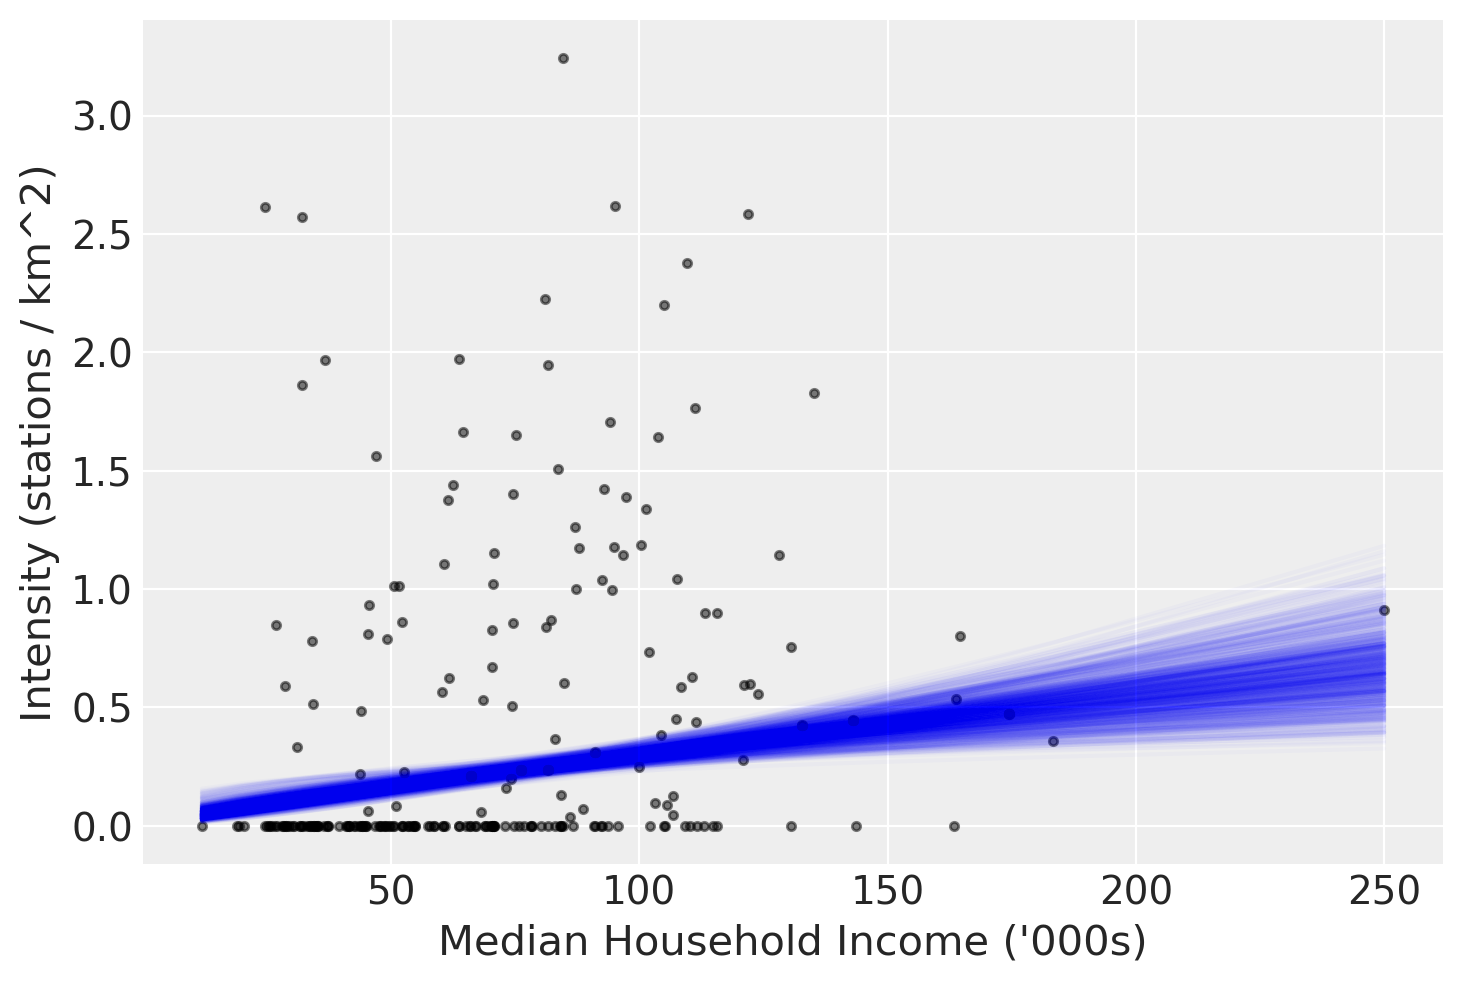

In [37]:
order = np.argsort(log_income_std)
log_income_sorted = log_income_std[order]
income_sorted = np.array(count_data['income'])[order]

# Unormalize income sorted


plt.plot(income_sorted/1000, num_stations[order] / area[order], 'k.', alpha=0.5)

# plot the posterior predictive sample
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()
for i in range(1000):
    plt.plot(income_sorted/1000, np.exp(alpha[i] + beta[i] * log_income_sorted), 'b-', alpha=0.02)

plt.xlabel("Median Household Income ('000s)")
plt.ylabel("Intensity (stations / km^2)")


# Now, let's do the same thing, looking at stations per 1000 people

In [75]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    log_intensity = alpha + beta * log_income_std
    intensity = pm.math.exp(log_intensity)

    rates = intensity * population

    counts = pm.Poisson('counts', mu=rates, observed=num_stations)

In [76]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

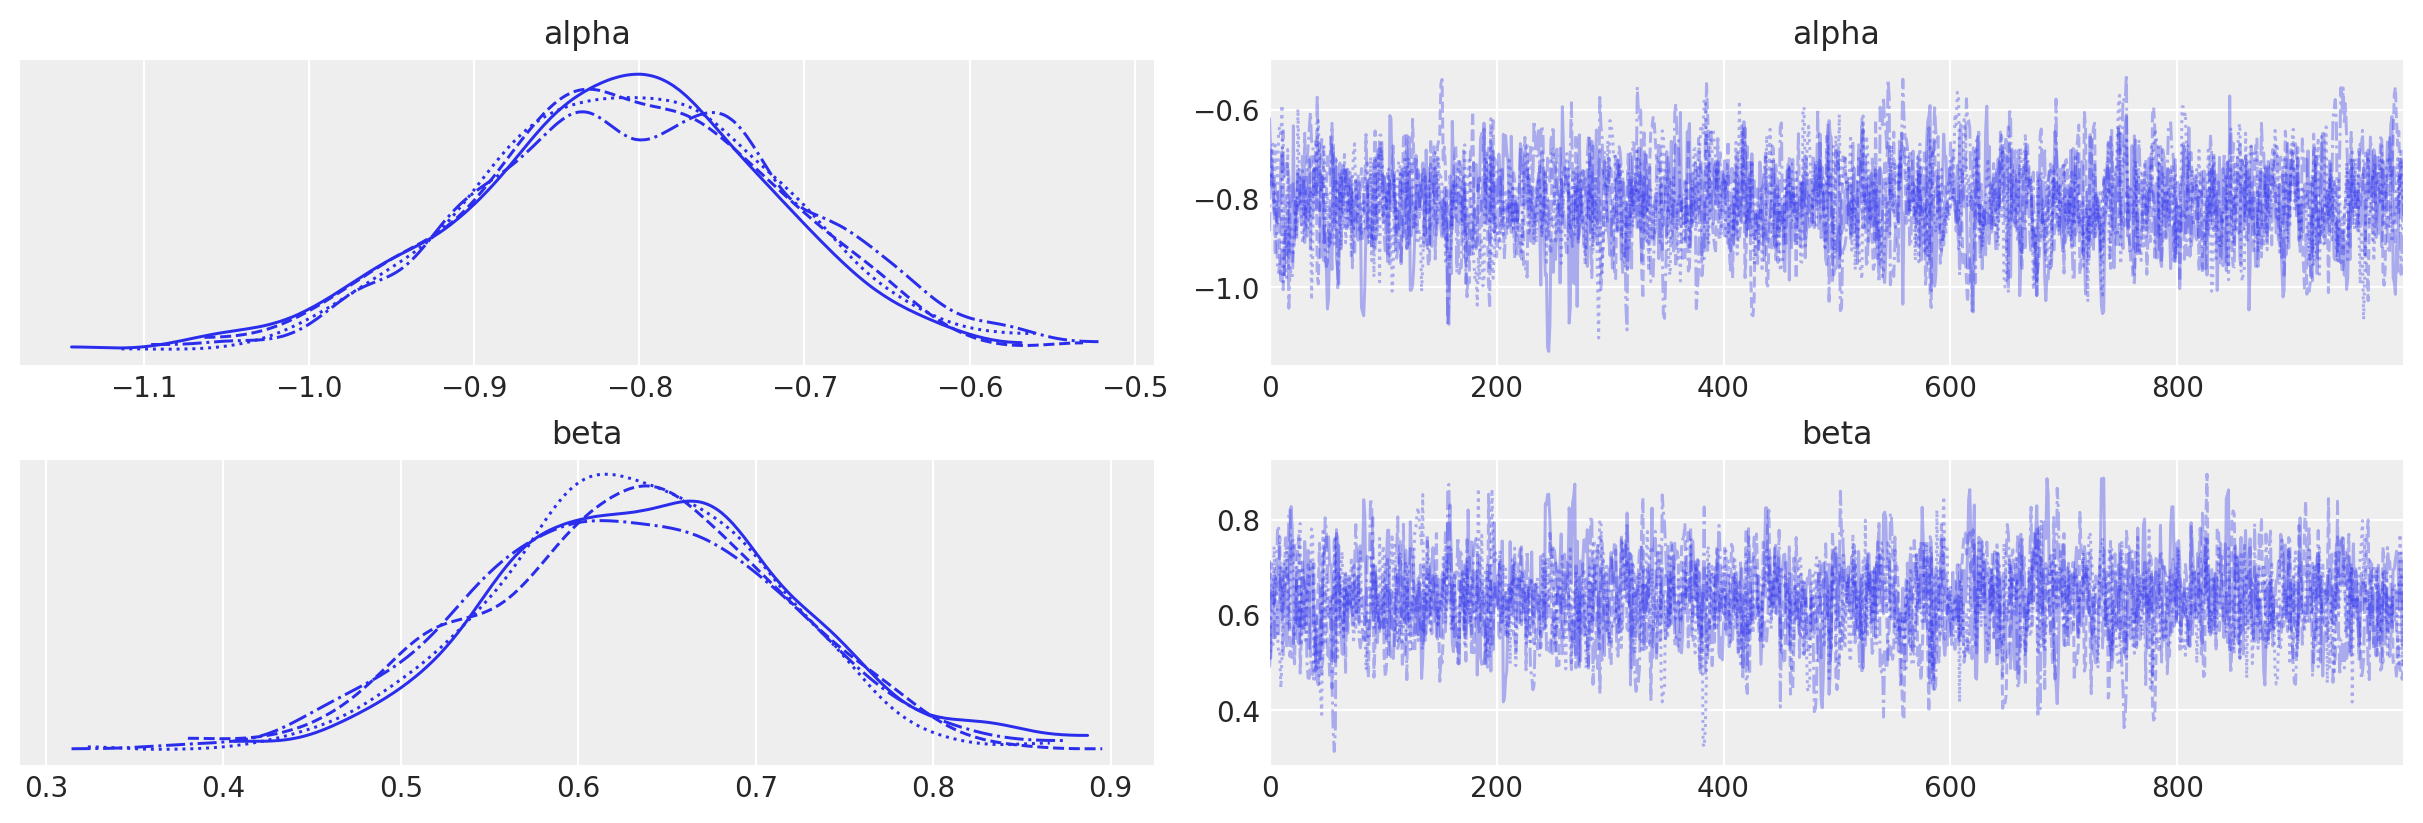

In [77]:
import arviz as az

az.plot_trace(trace)

In [78]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.808,0.093,-0.981,-0.635,0.002,0.002,1508.0,1726.0,1.0
beta,0.631,0.083,0.474,0.783,0.002,0.001,1643.0,1838.0,1.0


Text(0, 0.5, 'Intensity (stations / 1000 people)')

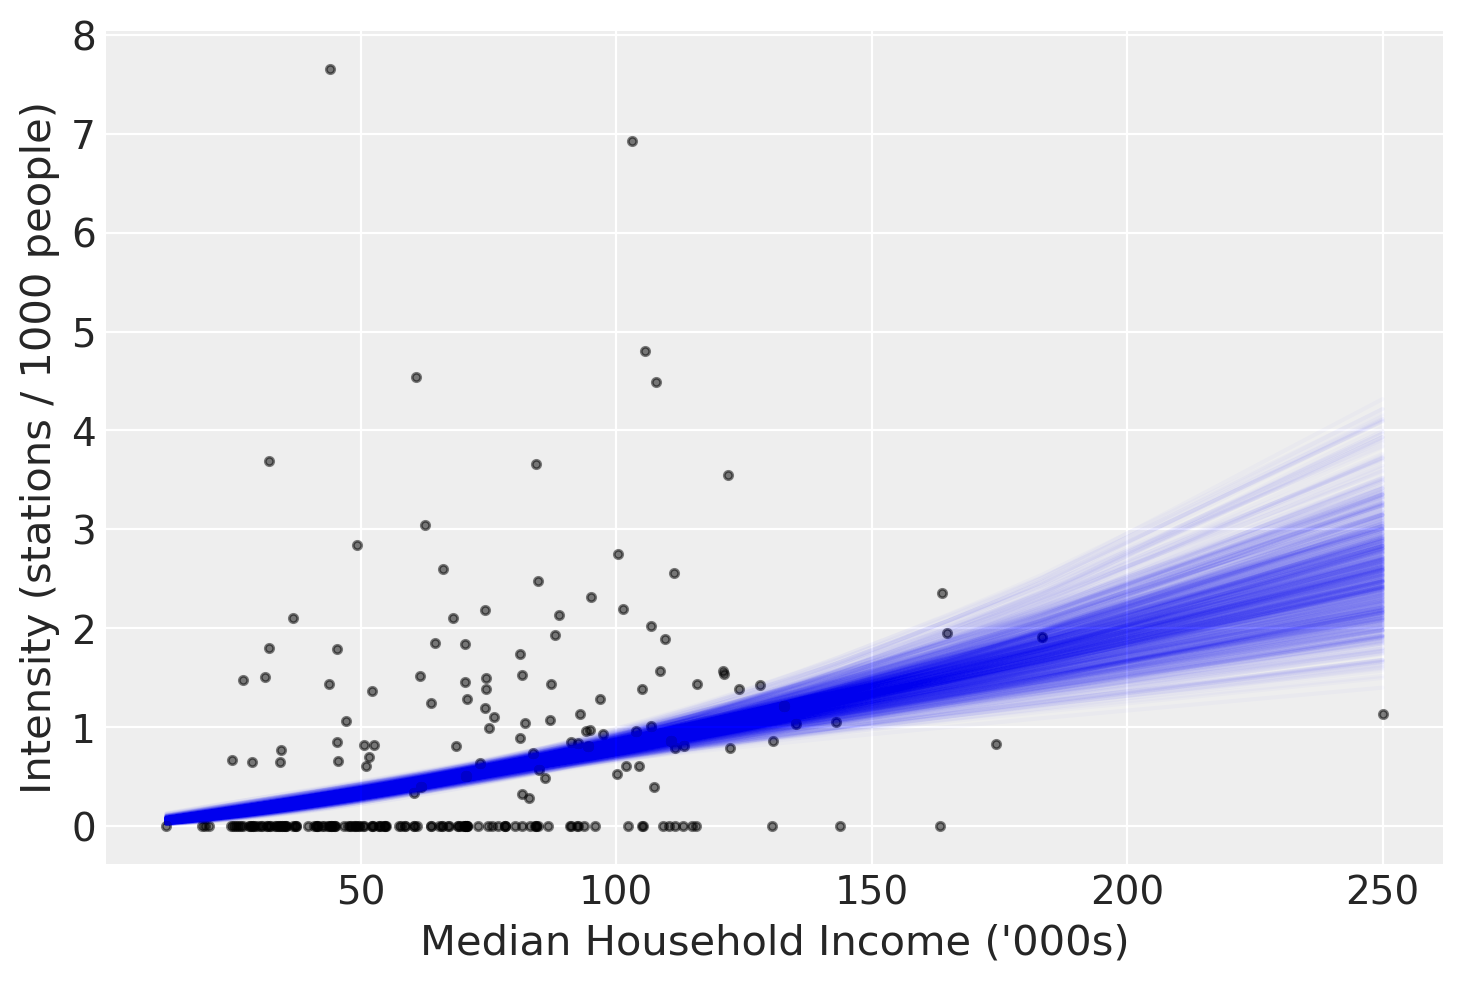

In [79]:
order = np.argsort(log_income_std)
log_income_sorted = log_income_std[order]
income_sorted = np.array(count_data['income'])[order]

# Unormalize income sorted


plt.plot(income_sorted/1000, num_stations[order] / population[order], 'k.', alpha=0.5)

# plot the posterior predictive sample
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()
for i in range(1000):
    plt.plot(income_sorted/1000, np.exp(alpha[i] + beta[i] * log_income_sorted), 'b-', alpha=0.02)

plt.xlabel("Median Household Income ('000s)")
plt.ylabel("Intensity (stations / 1000 people)")

(array([134.,  55.,   0.,  30.,   0.,   7.,   4.,   0.,   2.,   3.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

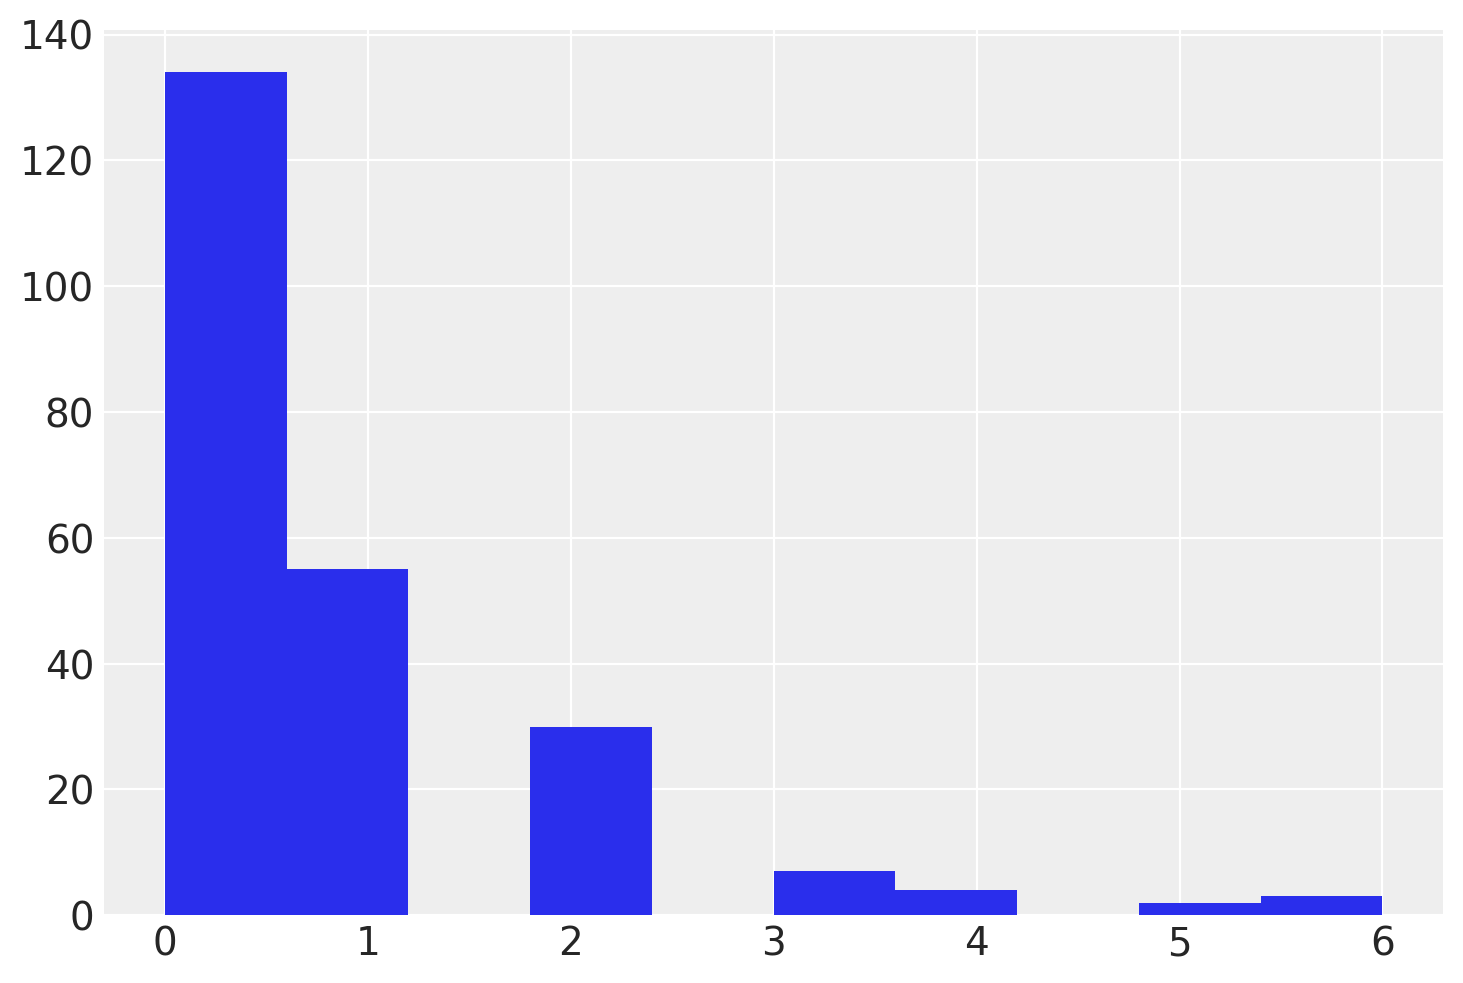

In [51]:
plt.hist(num_stations)

In [44]:
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()

intensity = np.exp(alpha.mean() + beta.mean() * log_income_std)

In [47]:
block_groups = block_groups[block_groups['pop'] != 0]
block_groups['pop'] = intensity

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

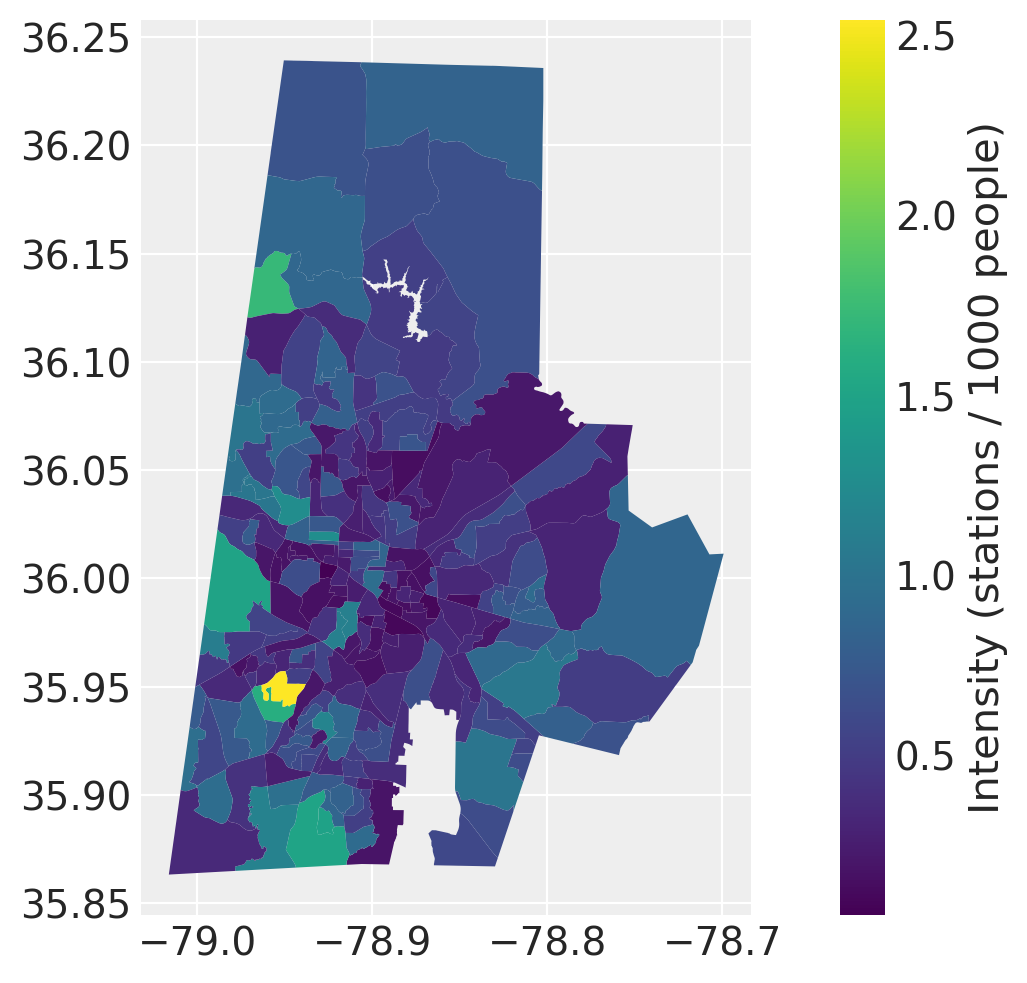

In [50]:
# plt.subplots(1,2)
# plt.subplot(2,1,1)
block_groups.plot(column='pop', legend=True, cmap='viridis', legend_kwds={
    "label": "Intensity (stations / 1000 people)"
})


In [55]:
block_groups['num_stations'] = num_stations

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

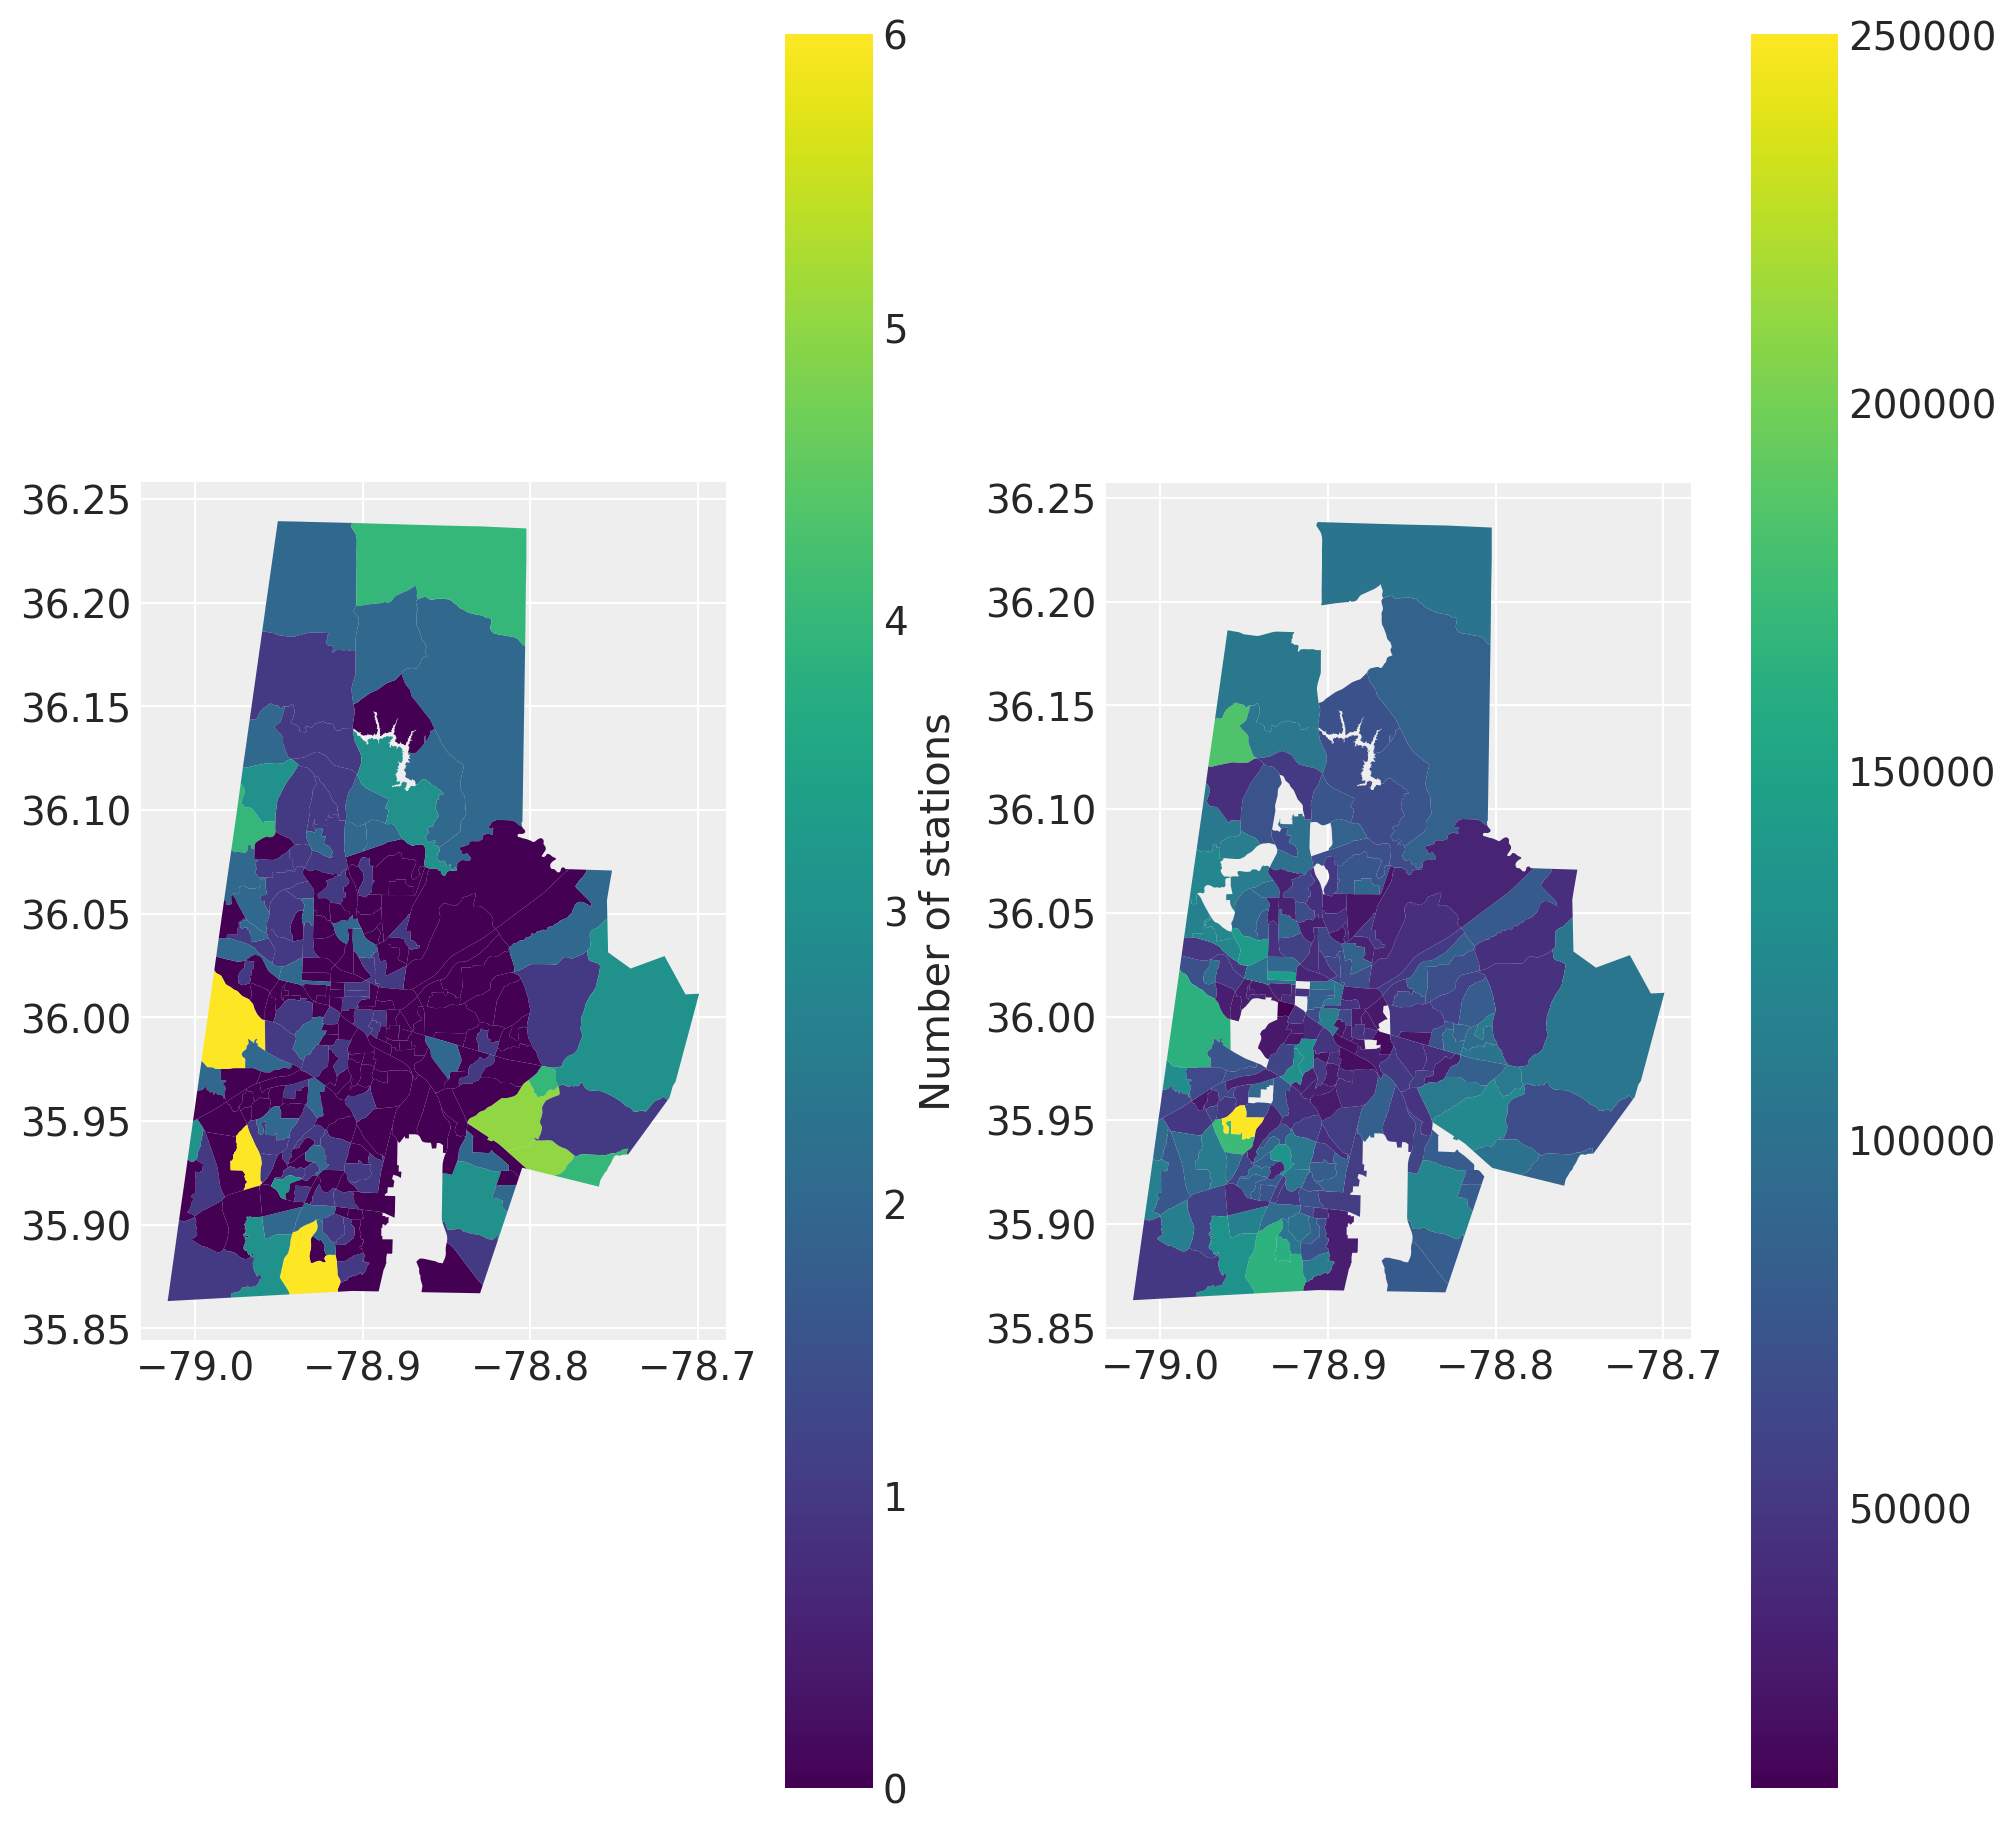

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
block_groups.plot(column='num_stations', legend=True, cmap='viridis', legend_kwds={
    "label": "Number of stations"
}, ax=ax1)

block_groups.plot(column='income', legend=True, cmap='viridis', ax=ax2)